--------------------------------------------------------
        area     price           street        ward    district
36  4.400603  1.178655  Hoàng Phan Thái  Bình Chánh  Bình Chánh
56  4.403054  1.193922  Hoàng Phan Thái  Bình Chánh  Bình Chánh
46  4.405499  1.193922  Hoàng Phan Thái  Bình Chánh  Bình Chánh
40  4.406719  1.193922  Hoàng Phan Thái  Bình Chánh  Bình Chánh
34  4.420045  1.435085  Hoàng Phan Thái  Bình Chánh  Bình Chánh
--------------------------------------------------------
Log Transformation Data length:  55
Model coefficient:  [[0.50734443]]
Model intercept  [-1.11262047]


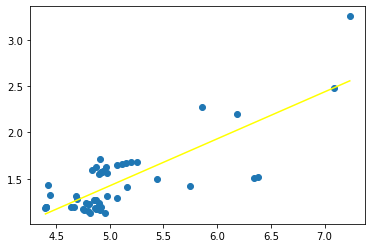

Root Mean Square Error:  0.22971058030706484


Use polynomial regression with degree = 2: 


Model coefficient:  [[ 0.         -1.03300636  0.13569645]]
Model intercept:  [3.15854632]


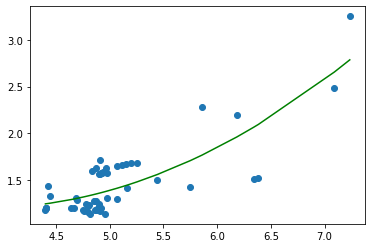

Root Mean Square Error:  0.21998829806240333


Use polynomial regression with degree = 3: 


Model coefficient:  [[ 0.         13.05543319 -2.38438331  0.14804661]]
Model intercept:  [-22.75445839]


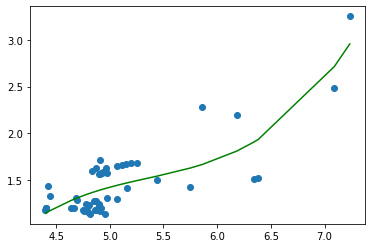

Root Mean Square Error:  0.21126095795655295


Use polynomial regression with degree = 4: 


Model coefficient:  [[   0.         -320.4809653    87.57550979  -10.51852015    0.46902644]]
Model intercept:  [436.12965102]


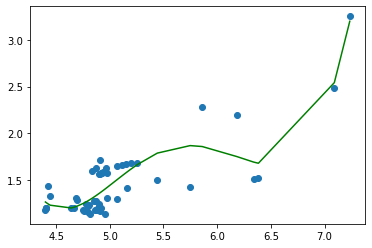

Root Mean Square Error:  0.18298936060120588


Use polynomial regression with degree = 5: 


Model coefficient:  [[ 0.00000000e+00  4.21708836e+02 -1.79622705e+02  3.72227736e+01
  -3.76405028e+00  1.48998037e-01]]
Model intercept:  [-382.48570109]


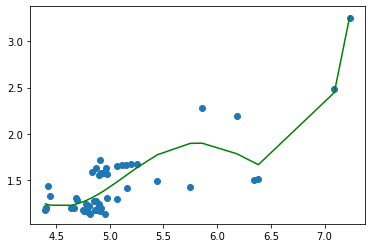

Root Mean Square Error:  0.18152889743200562


Use polynomial regression with degree = 6: 


Model coefficient:  [[ 0.00000000e+00 -3.26106844e+03  1.45981406e+03 -3.49638847e+02
   4.72724460e+01 -3.42008771e+00  1.03370364e-01]]
Model intercept:  [3043.61375924]


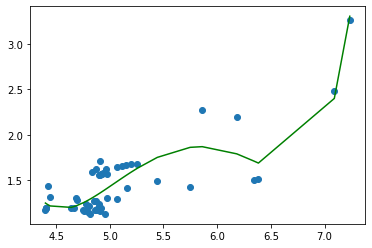

Root Mean Square Error:  0.18105829562441952


Use polynomial regression with degree = 7: 


Model coefficient:  [[ 0.00000000e+00 -1.45667570e+05  7.73026798e+04 -2.26723708e+04
   3.96867238e+03 -4.14562577e+02  2.39254980e+01 -5.88453425e-01]]
Model intercept:  [117043.47925728]


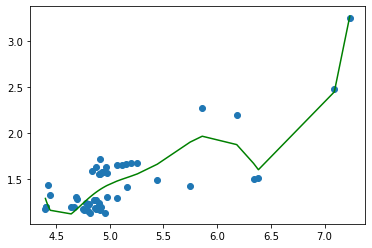

Root Mean Square Error:  0.17655879844418737


Use polynomial regression with degree = 8: 


Model coefficient:  [[ 0.00000000e+00  3.99442120e+06 -2.51741972e+06  9.02619428e+05
  -2.01371338e+05  2.86230332e+04 -2.53129470e+03  1.27335064e+02
  -2.78957870e+00]]
Model intercept:  [-2760825.65404185]


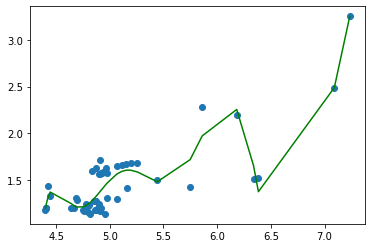

Root Mean Square Error:  0.15271285135298063


Use polynomial regression with degree = 9: 


Model coefficient:  [[ 0.00000000e+00  2.12431686e+05  1.90906117e+05 -2.24739516e+05
   9.92315012e+04 -2.46221445e+04  3.73365722e+03 -3.44843843e+02
   1.78949691e+01 -4.01268692e-01]]
Model intercept:  [-421820.28381424]


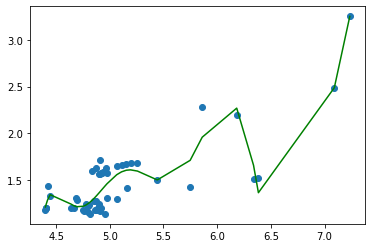

Root Mean Square Error:  0.15343013241437223


Use polynomial regression with degree = 10: 


Model coefficient:  [[ 0.00000000e+00  9.57434594e+05  6.59630658e+05 -9.59857720e+05
   4.88378188e+05 -1.41690482e+05  2.60411987e+04 -3.10170715e+03
   2.33144522e+02 -1.00851743e+01  1.91813697e-01]]
Model intercept:  [-1569844.86612432]


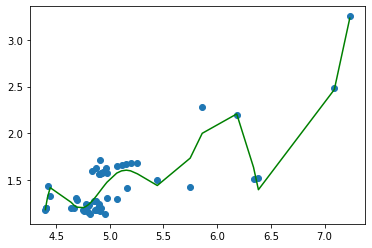

Root Mean Square Error:  0.15208077129122863


Use polynomial regression with degree = 11: 


Model coefficient:  [[ 0.00000000e+00  8.03188770e+04  1.42071750e+05  4.18898602e+04
  -1.35794990e+05  8.22670054e+04 -2.61987968e+04  5.12386174e+03
  -6.39393875e+02  4.99074724e+01 -2.22966370e+00  4.36477499e-02]]
Model intercept:  [-417119.1914311]


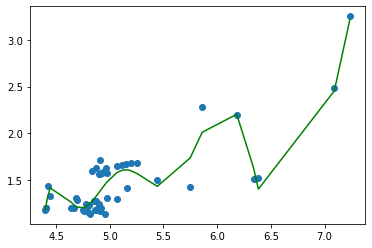

Root Mean Square Error:  0.1518510467007421


Use polynomial regression with degree = 12: 


Model coefficient:  [[ 0.00000000e+00  6.11584405e+03  1.65386516e+04  2.07066206e+04
   1.96299626e+03 -2.08419177e+04  1.42378133e+04 -4.83205595e+03
   9.86446555e+02 -1.27128715e+02  1.01833848e+01 -4.64995429e-01
   9.27805057e-03]]
Model intercept:  [-129537.36318892]


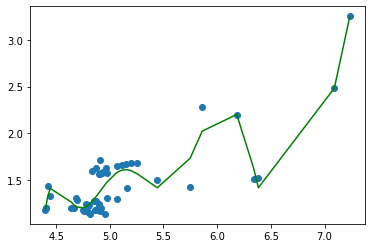

Root Mean Square Error:  0.15123304249524036


Use polynomial regression with degree = 13: 


Model coefficient:  [[ 0.00000000e+00  4.41819258e+02  1.51743861e+03  2.98209113e+03
   3.16211673e+03 -1.46064870e+02 -3.35841176e+03  2.49937909e+03
  -8.87283968e+02  1.86779224e+02 -2.46372061e+01  2.01077841e+00
  -9.32692360e-02  1.88646458e-03]]
Model intercept:  [-46281.64421707]


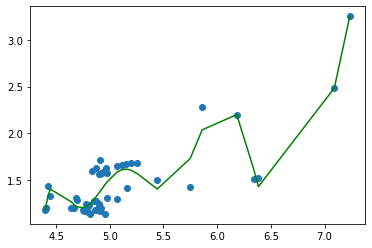

Root Mean Square Error:  0.15068472703258676


Use polynomial regression with degree = 14: 


Model coefficient:  [[ 0.00000000e+00  4.00199328e+01  1.20132593e+02  3.04733670e+02
   5.26366256e+02  5.03204280e+02 -7.74162921e+01 -5.58962196e+02
   4.42964281e+02 -1.62502252e+02  3.49917235e+01 -4.69628994e+00
   3.88703972e-01 -1.82436067e-02  3.72769313e-04]]
Model intercept:  [-18569.24929147]


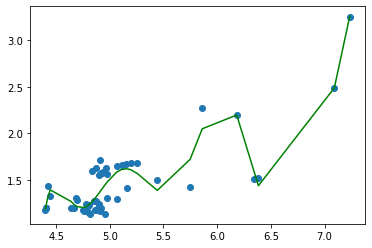

Root Mean Square Error:  0.15005915446384951


Use polynomial regression with degree = 15: 


Model coefficient:  [[ 0.00000000e+00  8.50346347e-01  8.53270761e+00  2.57059207e+01
   5.77553101e+01  9.26960431e+01  8.24378641e+01 -1.97010854e+01
  -9.49391421e+01  7.88909138e+01 -2.96648621e+01  6.49876515e+00
  -8.83891961e-01  7.39554005e-02 -3.50290502e-03  7.21413953e-05]]
Model intercept:  [-8155.11049252]


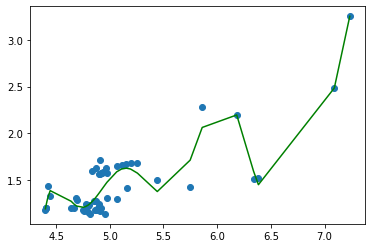

Root Mean Square Error:  0.14937377934060944


Use polynomial regression with degree = 16: 


Model coefficient:  [[ 0.00000000e+00  5.84486621e-05  3.27686382e-04  1.32993029e-03
   4.40106042e-03  1.21801063e-02  2.75587916e-02  4.72233168e-02
   4.87822523e-02 -1.79535007e-03 -5.86200311e-02  4.17092435e-02
  -1.35442337e-02  2.47206923e-03 -2.62428772e-04  1.51996302e-05
  -3.72757448e-07]]
Model intercept:  [-35.86406833]


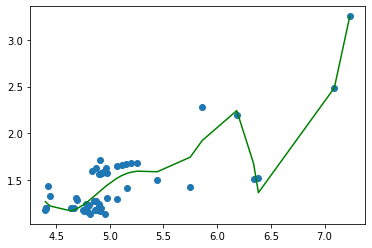

Root Mean Square Error:  0.1603024148293349


Use polynomial regression with degree = 17: 


Model coefficient:  [[ 0.00000000e+00  1.37859356e-06  6.75183816e-06  2.92728033e-05
   1.05450953e-04  3.26396909e-04  8.63610209e-04  1.88515944e-03
   3.11259203e-03  3.00425981e-03 -5.70947084e-04 -4.09865799e-03
   3.25252558e-03 -1.13217010e-03  2.18057187e-04 -2.41937575e-05
   1.45455280e-06 -3.68334841e-08]]
Model intercept:  [5.45957087]


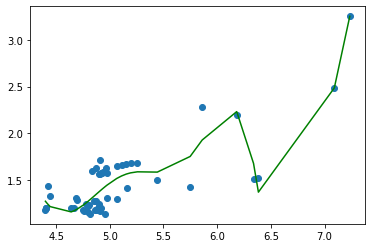

Root Mean Square Error:  0.1606833098610942


Use polynomial regression with degree = 18: 


Model coefficient:  [[ 0.00000000e+00 -1.27591167e-07 -1.57638365e-07 -7.30649453e-07
  -2.84509444e-06 -9.72669481e-06 -2.93757924e-05 -7.73293237e-05
  -1.71441153e-04 -2.97961137e-04 -3.40287759e-04 -9.85149457e-05
   2.63471780e-04 -9.39403880e-05  8.09020533e-06  2.00750837e-06
  -5.39764222e-07  4.82089604e-08 -1.55714611e-09]]
Model intercept:  [17.5252498]


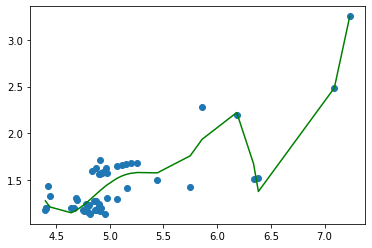

Root Mean Square Error:  0.16081515213623432


Use polynomial regression with degree = 19: 


Model coefficient:  [[ 0.00000000e+00 -3.58120436e-08 -3.13866965e-08 -1.50534390e-07
  -6.16789627e-07 -2.24451322e-06 -7.33274230e-06 -2.13844222e-05
  -5.45664286e-05 -1.17015564e-04 -1.94222079e-04 -2.00922073e-04
  -1.18279794e-05  2.08259689e-04 -1.28464417e-04  3.66754791e-05
  -5.88311559e-06  5.46761037e-07 -2.75641105e-08  5.83996010e-10]]
Model intercept:  [19.21615105]


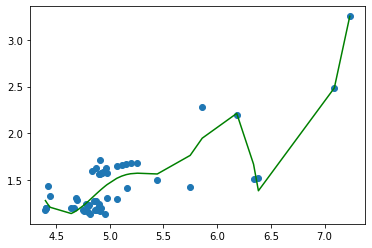

Root Mean Square Error:  0.16068781897817505


Use polynomial regression with degree = 20: 


Model coefficient:  [[ 0.00000000e+00 -5.26949678e-09 -2.75164784e-09 -1.28969489e-08
  -5.53172592e-08 -2.12668196e-07 -7.43442898e-07 -2.36227716e-06
  -6.74839717e-06 -1.69386095e-05 -3.58016241e-05 -5.85192410e-05
  -5.90082813e-05 -5.10337733e-07  6.40558326e-05 -4.18578592e-05
   1.25706190e-05 -2.12417120e-06  2.08804159e-07 -1.11987000e-08
   2.54324802e-10]]
Model intercept:  [17.46933717]


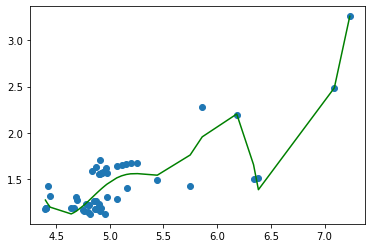

Root Mean Square Error:  0.1602962291841947


Use polynomial regression with degree = 21: 


Model coefficient:  [[ 0.00000000e+00 -5.09497565e-09 -1.38575338e-10 -8.75921364e-10
  -3.90502157e-09 -1.57189549e-08 -5.80849356e-08 -1.97633667e-07
  -6.15767002e-07 -1.73292857e-06 -4.29772419e-06 -8.99020717e-06
  -1.45446148e-05 -1.44426261e-05  2.59891208e-07  1.60085649e-05
  -1.07308339e-05  3.28804297e-06 -5.66207269e-07  5.67076020e-08
  -3.09937252e-09  7.17600503e-11]]
Model intercept:  [14.85282352]


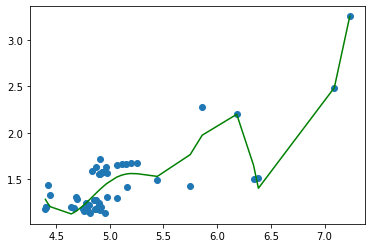

Root Mean Square Error:  0.15964129811501346


Use polynomial regression with degree = 22: 


Model coefficient:  [[ 0.00000000e+00  2.47392266e-10  3.00003680e-12 -5.27055198e-11
  -2.43007194e-10 -1.01700288e-09 -3.93569078e-09 -1.41590641e-08
  -4.72561824e-08 -1.45116444e-07 -4.03799615e-07 -9.92279566e-07
  -2.05936677e-06 -3.30617607e-06 -3.24716263e-06  1.16274349e-07
   3.64493391e-06 -2.48123508e-06  7.69050149e-07 -1.33805143e-07
   1.35330404e-08 -7.46741379e-10  1.74526589e-11]]
Model intercept:  [12.28339396]


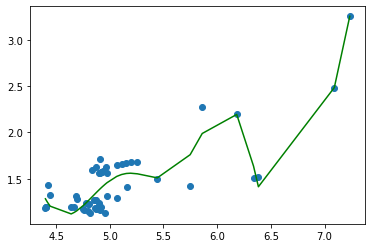

Root Mean Square Error:  0.15873242586528072


Use polynomial regression with degree = 23: 


Model coefficient:  [[ 0.00000000e+00 -4.73302785e-10 -9.71115471e-13 -2.85483102e-12
  -1.39017255e-11 -6.01530573e-11 -2.42062259e-10 -9.12179610e-10
  -3.21969624e-09 -1.05939067e-08 -3.21771018e-08 -8.87593439e-08
  -2.16562957e-07 -4.46699731e-07 -7.12908017e-07 -6.94407128e-07
   3.39090686e-08  7.86325377e-07 -5.41007200e-07  1.68968939e-07
  -2.95954032e-08  3.01184316e-09 -1.67170334e-10  3.92924945e-12]]
Model intercept:  [10.04640751]


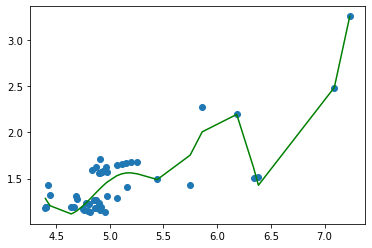

Root Mean Square Error:  0.1575914743611395


Use polynomial regression with degree = 24: 


Model coefficient:  [[ 0.00000000e+00 -2.95839897e-11  1.08293896e-12 -1.65249011e-13
  -7.45626815e-13 -3.32164719e-12 -1.38225691e-11 -5.41730533e-11
  -2.00325101e-10 -6.97227664e-10 -2.26960710e-09 -6.83572947e-09
  -1.87293162e-08 -4.54445113e-08 -9.32909142e-08 -1.48207428e-07
  -1.43449843e-07  8.42143574e-09  1.63509658e-07 -1.13381865e-07
   3.56068379e-08 -6.26610252e-09  6.40425409e-10 -3.56891750e-11
   8.42050202e-13]]
Model intercept:  [8.19056333]


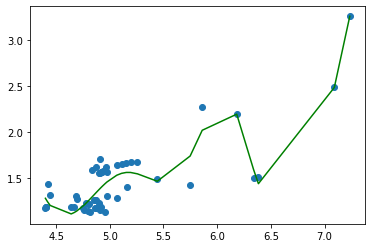

Root Mean Square Error:  0.15625794590723643


Use polynomial regression with degree = 25: 


Model coefficient:  [[ 4.40463623e-10 -2.19503690e-11  8.35440663e-13 -6.70739385e-14
  -4.37753180e-14 -1.95688822e-13 -8.29336690e-13 -3.32577990e-12
  -1.26577556e-11 -4.56825689e-11 -1.55714661e-10 -4.97647714e-10
  -1.47423679e-09 -3.97835814e-09 -9.51648646e-09 -1.92691050e-08
  -3.01819667e-08 -2.86829090e-08  2.24073292e-09  3.27097940e-08
  -2.29105110e-08  7.23560046e-09 -1.27882971e-09  1.31181951e-10
  -7.33429065e-12  1.73561964e-13]]
Model intercept:  [6.68618054]


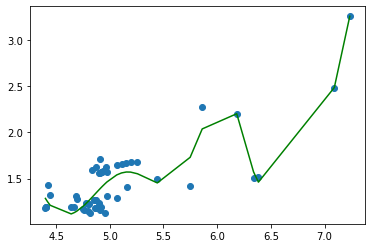

Root Mean Square Error:  0.1547979001915755


Use polynomial regression with degree = 26: 


Model coefficient:  [[ 1.14466193e-10  4.57844749e-10 -6.23422646e-14 -1.12162007e-14
  -2.00872596e-15 -9.82483684e-15 -4.27131019e-14 -1.76333187e-13
  -6.94035060e-13 -2.60519095e-12 -9.30391352e-12 -3.14555895e-11
  -9.98830236e-11 -2.94373447e-10 -7.91080684e-10 -1.88579628e-09
  -3.80709762e-09 -5.94643571e-09 -5.62906107e-09  4.74322529e-10
   6.44620470e-09 -4.53631131e-09  1.43725866e-09 -2.54705293e-10
   2.61899396e-11 -1.46745090e-12  3.47965392e-14]]
Model intercept:  [5.47165043]


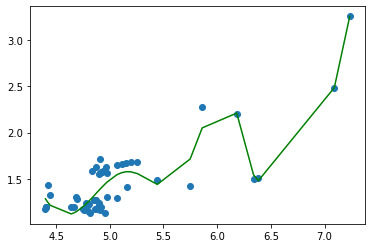

Root Mean Square Error:  0.15329442877060695


Use polynomial regression with degree = 27: 


Model coefficient:  [[ 2.90303705e-11  1.28519760e-10  9.55684099e-14 -2.80800666e-15
  -1.30251812e-16 -4.70720285e-16 -2.09415598e-15 -8.86825918e-15
  -3.59372241e-14 -1.39520612e-13 -5.18302912e-13 -1.83620768e-12
  -6.16906634e-12 -1.94915587e-11 -5.72166085e-11 -1.53267059e-10
  -3.64403634e-10 -7.34038753e-10 -1.14414246e-09 -1.07995874e-09
   9.60925047e-11  1.24103660e-09 -8.76544195e-10  2.78413430e-10
  -4.94419318e-11  5.09316506e-12 -2.85849478e-13  6.78847372e-15]]
Model intercept:  [4.4982276]


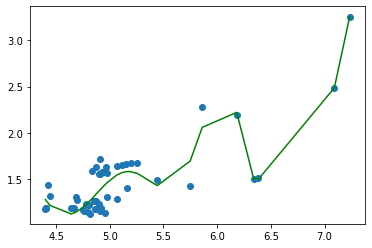

Root Mean Square Error:  0.1518676920590079


Use polynomial regression with degree = 28: 


Model coefficient:  [[ 7.05863811e-12  2.76364140e-12  2.19356435e-14 -5.04193054e-17
  -3.83507098e-18 -1.81290744e-17 -8.31947759e-17 -3.64644730e-16
  -1.53388382e-15 -6.20380257e-15 -2.41159368e-14 -8.99038615e-14
  -3.20148113e-13 -1.08244297e-12 -3.44495128e-12 -1.01933058e-11
  -2.75387616e-11 -6.60688824e-11 -1.34363708e-10 -2.11619618e-10
  -2.02385241e-10  1.60088332e-11  2.34459296e-10 -1.65300404e-10
   5.25153335e-11 -9.33221148e-12  9.62122544e-13 -5.40442120e-14
   1.28454998e-15]]
Model intercept:  [3.70104594]


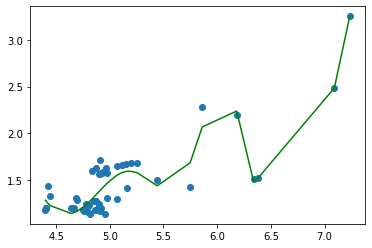

Root Mean Square Error:  0.15064876176886746


Use polynomial regression with degree = 29: 


Model coefficient:  [[ 1.74499202e-12 -7.91443920e-12  3.31466589e-15  7.34852808e-17
  -4.38165177e-19 -9.39513514e-19 -4.37578618e-18 -1.93390340e-17
  -8.22449413e-17 -3.37362209e-16 -1.33512148e-15 -5.09103805e-15
  -1.86522332e-14 -6.53703061e-14 -2.17774603e-13 -6.83526399e-13
  -1.99607139e-12 -5.32528171e-12 -1.26212720e-11 -2.53599405e-11
  -3.94410927e-11 -3.71129027e-11  3.52284227e-12  4.28883609e-11
  -3.04436206e-11  9.70327943e-12 -1.72813064e-12  1.78470546e-13
  -1.00392379e-14  2.38907982e-16]]
Model intercept:  [3.10176832]


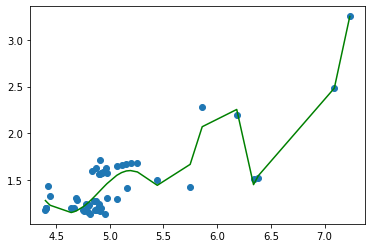

Root Mean Square Error:  0.1497802147002043


Use polynomial regression with degree = 30: 


Model coefficient:  [[ 4.03586007e-13  4.94195616e-14  1.16885449e-15  6.58185405e-18
  -1.71640110e-20 -3.29286486e-20 -1.54990973e-19 -7.06575203e-19
  -3.10579103e-18 -1.31995184e-17 -5.42822264e-17 -2.15862600e-16
  -8.28454676e-16 -3.05860810e-15 -1.08118130e-14 -3.63539119e-14
  -1.15228176e-13 -3.39958300e-13 -9.16636969e-13 -2.19643795e-12
  -4.46401235e-12 -7.02877670e-12 -6.71844950e-12  5.52113190e-13
   7.82498570e-12 -5.53609357e-12  1.76339178e-12 -3.14059399e-13
   3.24420904e-14 -1.82554115e-15  4.34596577e-17]]
Model intercept:  [2.61947674]


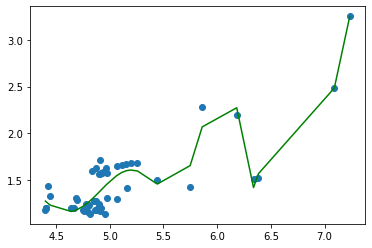

Root Mean Square Error:  0.14936393888872537


Use polynomial regression with degree = 31: 


Model coefficient:  [[ 9.47676137e-14 -2.82461284e-13  1.09825514e-16  4.79247817e-18
  -9.50683250e-22 -1.82486969e-21 -7.62052501e-21 -3.48781108e-20
  -1.54170194e-19 -6.60380004e-19 -2.74442762e-18 -1.10637763e-17
  -4.32102893e-17 -1.63106987e-16 -5.92957299e-16 -2.06586500e-15
  -6.85165268e-15 -2.14350167e-14 -6.24514889e-14 -1.66359975e-13
  -3.93936755e-13 -7.91237999e-13 -1.23051628e-12 -1.15763168e-12
   1.12706710e-13  1.34408828e-12 -9.56815989e-13  3.05621186e-13
  -5.45293717e-14  5.64040782e-15 -3.17729544e-16  7.57071889e-18]]
Model intercept:  [2.22955222]


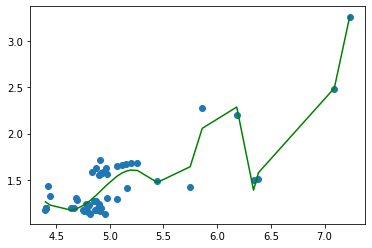

Root Mean Square Error:  0.14947396024270687


Use polynomial regression with degree = 32: 


Model coefficient:  [[ 2.07687334e-14 -1.08807267e-14 -2.82762870e-18 -9.49548160e-16
  -7.03859503e-18  3.63454637e-17  5.18714901e-19  7.94954458e-18
   8.10447610e-16 -2.22405091e-20 -9.56224275e-20 -3.99778489e-19
  -1.62397392e-18 -6.39867378e-18 -2.43887383e-17 -8.95869983e-17
  -3.15535451e-16 -1.05835984e-15 -3.34951879e-15 -9.87473216e-15
  -2.66224368e-14 -6.38184208e-14 -1.29811415e-13 -2.04629635e-13
  -1.95846801e-13  1.62700400e-14  2.29178723e-13 -1.62487084e-13
   5.18470724e-14 -9.24794890e-15  9.56579970e-16 -5.38911177e-17
   1.28430821e-18]]
Model intercept:  [1.9236619]


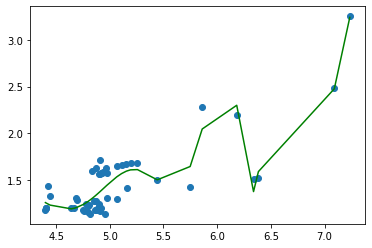

Root Mean Square Error:  0.15008920155550784


Use polynomial regression with degree = 33: 


Model coefficient:  [[ 3.68535464e-15 -8.50755199e-15  4.17600206e-16 -6.05743104e-17
   5.63745127e-17 -1.78657815e-17 -3.77256296e-20  7.51802354e-18
   1.77436485e-16 -8.67194843e-22 -3.80005690e-21 -1.62271017e-20
  -6.74989411e-20 -2.73167320e-19 -1.07338939e-18 -4.08342964e-18
  -1.49806034e-17 -5.27238850e-17 -1.76787710e-16 -5.59515492e-16
  -1.65002679e-15 -4.45095118e-15 -1.06776553e-14 -2.17389054e-14
  -3.43039316e-14 -3.28681523e-14  2.73959835e-15  3.85720935e-14
  -2.73798455e-14  8.74534892e-15 -1.56129733e-15  1.61623471e-16
  -9.11182610e-18  2.17285047e-19]]
Model intercept:  [1.68859572]


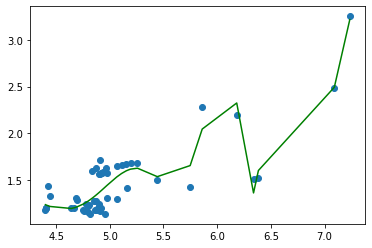

Root Mean Square Error:  0.15132353630787104


Use polynomial regression with degree = 34: 


Model coefficient:  [[ 2.13951438e-16 -3.86767578e-15  1.26126802e-16 -2.60943266e-17
  -1.89914905e-17  7.59014862e-18 -2.53271045e-18  1.52847265e-18
   2.00540034e-16  4.67629162e-17 -1.01330041e-15 -2.09075060e-16
  -3.55990983e-16 -5.74711390e-21 -2.40362022e-20 -9.74729238e-20
  -3.82167223e-19 -1.44306903e-18 -5.22088225e-18 -1.79738941e-17
  -5.83391804e-17 -1.76252991e-16 -4.86607432e-16 -1.19379426e-15
  -2.48418615e-15 -4.00732092e-15 -3.93886158e-15  2.61160488e-16
   4.70142652e-15 -3.33235326e-15  1.06637350e-15 -1.90861717e-16
   1.98104090e-17 -1.11977247e-18  2.67695221e-20]]
Model intercept:  [1.36558861]


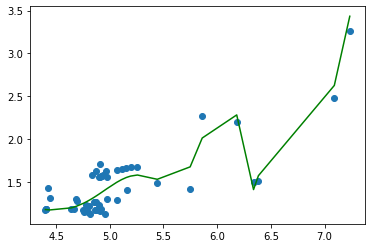

Root Mean Square Error:  0.15716481794866255


Use polynomial regression with degree = 35: 


Model coefficient:  [[ 2.35539488e-18  1.17566495e-16  7.41072701e-17 -2.20478446e-17
   4.78551884e-18 -3.84612382e-19  9.56126463e-20  3.30760183e-19
   1.70143670e-16 -4.39628023e-16 -1.42362413e-17 -3.00276205e-24
  -1.25557168e-23 -5.12963896e-23 -2.04534842e-22 -7.94554558e-22
  -2.99987309e-21 -1.09725635e-20 -3.87184091e-20 -1.31086052e-19
  -4.22764773e-19 -1.28631658e-18 -3.64335344e-18 -9.42293463e-18
  -2.16042309e-17 -4.17605387e-17 -6.15195053e-17 -5.11566723e-17
   1.93387199e-17  7.29217719e-17 -6.17578254e-17  2.19457688e-17
  -4.25043065e-18  4.70381776e-19 -2.80621338e-20  7.02693188e-22]]
Model intercept:  [1.06472404]


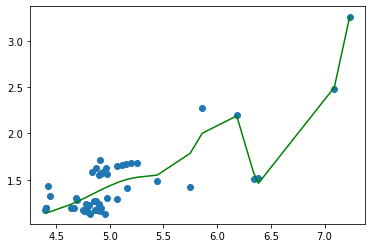

Root Mean Square Error:  0.16551432081201747


Use polynomial regression with degree = 36: 


Model coefficient:  [[-1.25210193e-20 -3.26898607e-20  5.49678178e-22 -3.78033478e-22
   2.20183453e-23  1.72236232e-23 -1.38707268e-23  8.42029454e-23
   6.94458820e-30  3.41003646e-29  1.64227447e-28  7.76840061e-28
   3.61171218e-27  1.65057083e-26  7.41183793e-26  3.26756325e-25
   1.41243518e-24  5.97570355e-24  2.46873150e-23  9.92933467e-23
   3.87309519e-22  1.45793227e-21  5.26202323e-21  1.80539717e-20
   5.81958275e-20  1.73320569e-19  4.65103608e-19  1.07961619e-18
   2.00996054e-18  2.50581085e-18  7.68492151e-19 -2.57484384e-18
   1.29472210e-18 -3.03381690e-19  3.80899743e-20 -2.49000416e-21
   6.68690748e-23]]
Model intercept:  [1.05035695]


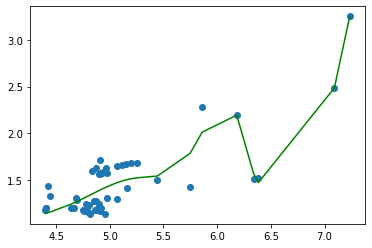

Root Mean Square Error:  0.16574529544540526


Use polynomial regression with degree = 37: 


Model coefficient:  [[ 1.32779407e-19  5.34224949e-18 -1.34935136e-18  3.29327649e-19
  -7.86151290e-20  2.01133376e-20 -6.03558820e-21  1.69582923e-20
   1.61307982e-18 -2.22654242e-19  2.44278014e-19 -3.75738153e-18
   5.13097069e-18 -1.65551052e-18 -1.35695411e-18 -1.06194799e-25
  -3.83131618e-25 -1.32651165e-24 -4.36990701e-24 -1.35177693e-23
  -3.84025370e-23 -9.59240309e-23 -1.88229215e-22 -1.57441530e-22
   9.21191074e-22  6.68261488e-21  2.81745889e-20  9.07882535e-20
   2.30612889e-19  4.38627977e-19  5.20350799e-19  1.06493377e-19
  -4.90005728e-19  2.52467035e-19 -5.97296128e-20  7.53922104e-21
  -4.94571164e-22  1.33150979e-23]]
Model intercept:  [1.06401242]


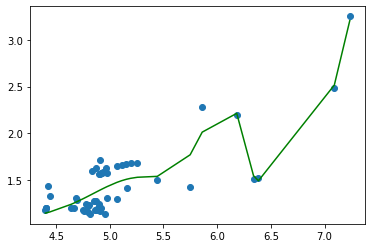

Root Mean Square Error:  0.16435079198852234


Use polynomial regression with degree = 38: 


Model coefficient:  [[-8.23772929e-22 -4.98856047e-20  2.05807857e-19 -5.97938714e-20
   9.89722929e-21 -2.65279558e-21  5.02407200e-22 -4.96488976e-22
   1.84324769e-19 -3.08312191e-19  3.56198191e-19 -4.11282061e-20
   2.61833364e-20 -2.62181864e-20 -9.96182392e-20  5.79876603e-20
  -3.01019260e-26 -1.16072505e-25 -4.35312128e-25 -1.58224311e-24
  -5.54815668e-24 -1.86548057e-23 -5.96530508e-23 -1.79334186e-22
  -4.98228933e-22 -1.24403028e-21 -2.64942426e-21 -4.22738565e-21
  -2.47772991e-21  1.28388697e-20  5.56369960e-20  1.08713896e-19
   6.31369975e-20 -1.29900508e-19  6.12649238e-20 -1.39647677e-20
   1.72619754e-21 -1.11727270e-22  2.98003806e-24]]
Model intercept:  [1.07250685]


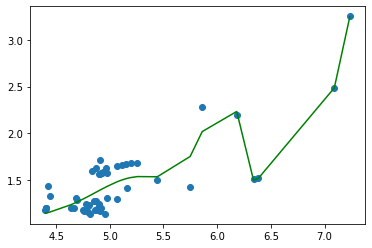

Root Mean Square Error:  0.16254165527652067


Use polynomial regression with degree = 39: 


Model coefficient:  [[-1.95462814e-22 -1.78245836e-20 -7.70244177e-21  3.81724729e-21
  -1.34706775e-21  3.34326058e-22 -5.17785644e-23  1.28577297e-22
  -7.33726074e-21  7.08037447e-21 -1.25290209e-20  7.06572976e-20
  -2.02364974e-20  1.43296206e-29  6.21829590e-29  2.65406385e-28
   1.11335803e-27  4.58536453e-27  1.85141103e-26  7.31508972e-26
   2.82173116e-25  1.05957434e-24  3.85916675e-24  1.35713413e-23
   4.58141958e-23  1.47354889e-22  4.47092747e-22  1.26242001e-21
   3.25386170e-21  7.43625919e-21  1.43658644e-20  2.14255483e-20
   1.95188521e-20 -2.97885825e-24 -1.62851205e-20  9.00696561e-21
  -2.19170300e-21  2.81031245e-22 -1.86258131e-23  5.05136644e-25]]
Model intercept:  [1.08701611]


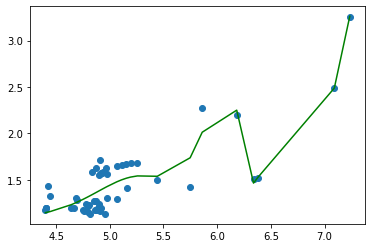

Root Mean Square Error:  0.1614737286756995


Use polynomial regression with degree = 40: 


Model coefficient:  [[-4.43901202e-23  4.17172402e-22 -1.54772299e-21  9.18673767e-24
   2.01566401e-22  4.57395011e-23 -5.51769342e-23 -1.80198327e-21
  -2.29985963e-21  1.34647279e-22 -2.35935588e-22 -2.47813365e-21
   4.03369556e-21 -9.95478067e-21 -3.57595788e-21 -1.81223212e-23
  -1.51474655e-28 -5.96265832e-28 -2.29150994e-27 -8.57593857e-27
  -3.11542110e-26 -1.09405062e-25 -3.69429955e-25 -1.19110770e-24
  -3.63195384e-24 -1.03317337e-23 -2.68525399e-23 -6.15328699e-23
  -1.15500502e-22 -1.41395416e-22  5.31169363e-23  8.86071417e-22
   2.65176976e-21  4.08181882e-21  1.43308726e-21 -4.14408389e-21
   2.04232727e-21 -4.74069681e-22  5.91870895e-23 -3.85484599e-24
   1.03254006e-25]]
Model intercept:  [1.10663361]


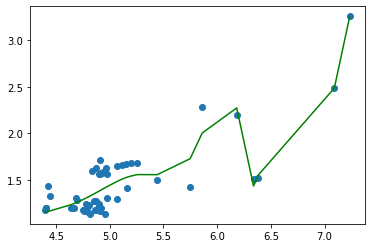

Root Mean Square Error:  0.16057244390921802


Use polynomial regression with degree = 41: 


Model coefficient:  [[-9.78140552e-24  7.05771648e-24  3.41387268e-23 -2.93768810e-24
   4.57861741e-25 -1.08620675e-25  3.25331057e-25  1.14385175e-24
  -1.00374868e-23  9.67323556e-24 -3.14136927e-23  1.39447480e-24
   4.38030343e-23  3.17442157e-22 -6.06009815e-25  1.15855097e-21
  -1.82394116e-21  1.07007218e-30  4.82508898e-30  2.14276516e-29
   9.35946340e-29  4.01438140e-28  1.68728186e-27  6.93192531e-27
   2.77487031e-26  1.07802357e-25  4.04404608e-25  1.45534799e-24
   4.98106106e-24  1.60233933e-23  4.76418193e-23  1.27677064e-22
   2.96072351e-22  5.50829585e-22  6.86475494e-22  2.10667804e-22
  -7.05333082e-22  3.54568660e-22 -8.30621964e-23  1.04261476e-23
  -6.81435016e-25  1.82968178e-26]]
Model intercept:  [1.12587781]


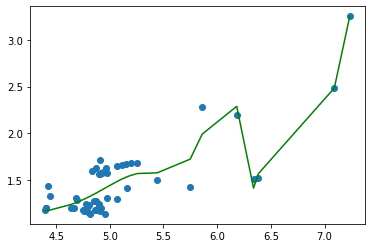

Root Mean Square Error:  0.1602908895268365


Use polynomial regression with degree = 42: 


Model coefficient:  [[-2.09977147e-24 -2.42534161e-24 -1.18240129e-23 -2.36154792e-23
   1.26278405e-23 -4.52818116e-24  1.45853689e-24 -5.04817016e-25
  -1.66245026e-24 -3.43910460e-24  1.07386448e-24  5.76640965e-25
  -1.42869648e-22  3.06838630e-23 -1.80203617e-23  1.49377417e-23
   1.35932650e-23  7.38566086e-32  3.19546730e-31  1.36569041e-30
   5.76065020e-30  2.39552843e-29  9.80639700e-29  3.94449207e-28
   1.55534150e-27  5.99401661e-27  2.24912329e-26  8.17670080e-26
   2.86167816e-25  9.55905685e-25  3.01196509e-24  8.80334468e-24
   2.32745151e-23  5.34304800e-23  9.87455822e-23  1.22673497e-22
   3.77969615e-23 -1.26050458e-22  6.32935863e-23 -1.48130322e-23
   1.85769767e-24 -1.21313017e-25  3.25468452e-27]]
Model intercept:  [1.14581496]


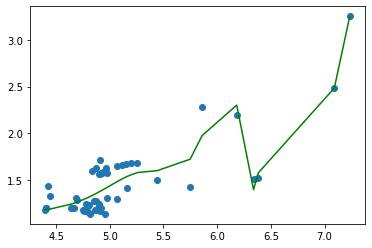

Root Mean Square Error:  0.16051058470620402


Use polynomial regression with degree = 43: 


Model coefficient:  [[-4.44215763e-25 -4.96603389e-24 -7.71998747e-24  1.72110778e-24
   5.84391236e-25 -9.61825737e-26 -1.42109215e-26  1.14821640e-24
  -8.84751496e-24  9.05124519e-24 -1.83022866e-23  1.91867943e-23
   4.47258251e-23 -2.34211897e-23  9.57662347e-24  3.52823999e-23
  -7.69037217e-23  3.63173921e-33  1.55116222e-32  6.54626901e-32
   2.72851462e-31  1.12249003e-30  4.55409384e-30  1.82017336e-29
   7.15644835e-29  2.76277527e-28  1.04468386e-27  3.85645017e-27
   1.38368304e-26  4.79657318e-26  1.59329862e-25  5.01333818e-25
   1.46957636e-24  3.91352394e-24  9.08831889e-24  1.70675219e-23
   2.16843862e-23  7.17468032e-24 -2.25766449e-23  1.12596626e-23
  -2.62621251e-24  3.28585956e-25 -2.14185948e-26  5.73760942e-28]]
Model intercept:  [1.16490812]


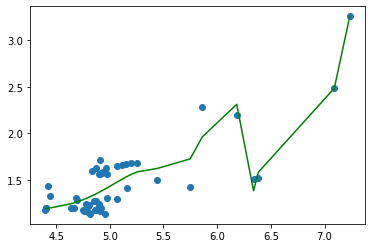

Root Mean Square Error:  0.1612112838057211


Use polynomial regression with degree = 44: 


Model coefficient:  [[-9.30407632e-26  1.76164883e-24  1.56409238e-24 -4.93665918e-25
   1.33461757e-25 -7.14717859e-26  1.55807845e-26  2.13719359e-25
   3.16720939e-24 -9.61336693e-25  8.45510769e-25  1.43019184e-25
  -1.94702839e-24 -3.94290239e-25  7.68227024e-24  4.91775807e-24
   1.27102353e-34  5.60535011e-34  2.44097451e-33  1.04891576e-32
   4.44374741e-32  1.85398301e-31  7.60703121e-31  3.06446319e-30
   1.20961334e-29  4.66688882e-29  1.75468415e-28  6.40566931e-28
   2.26015340e-27  7.66321445e-27  2.47831018e-26  7.57034921e-26
   2.15527547e-25  5.61190011e-25  1.29902146e-24  2.55191863e-24
   3.89767710e-24  3.70420092e-24  1.81432794e-25 -3.17179152e-24
   1.71599115e-24 -4.13048563e-25  5.25593034e-26 -3.46201806e-27
   9.33940621e-29]]
Model intercept:  [1.18393106]


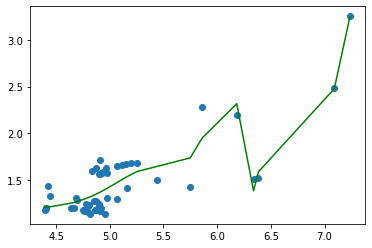

Root Mean Square Error:  0.1622526463700331


Use polynomial regression with degree = 45: 


Model coefficient:  [[-1.98214205e-26  1.96072252e-26  8.31845135e-26 -2.90700470e-26
   5.79180578e-27  4.31463338e-29  5.76355092e-28  2.38806158e-26
   9.63509234e-27  1.01951527e-25 -3.50327617e-26  1.46963528e-25
   2.38642370e-25 -1.74751818e-25  3.82679712e-25 -2.61291238e-25
   2.38346276e-36  1.08106333e-35  4.84897901e-35  2.14963285e-34
   9.41199825e-34  4.06638899e-33  1.73165089e-32  7.25850643e-32
   2.98992190e-31  1.20793471e-30  4.77492436e-30  1.84151930e-29
   6.90459263e-29  2.50581471e-28  8.75413486e-28  2.92318337e-27
   9.24344278e-27  2.73312733e-26  7.42295644e-26  1.80290834e-25
   3.74925589e-25  6.15372324e-25  6.51978557e-25  1.02857418e-25
  -6.00729404e-25  3.13246552e-25 -7.42810572e-26  9.37036519e-27
  -6.13571081e-28  1.64790297e-29]]
Model intercept:  [1.20021624]


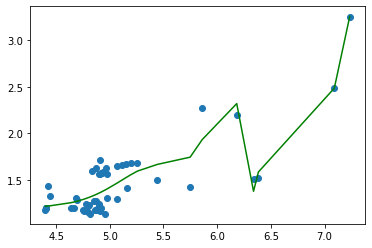

Root Mean Square Error:  0.16365563644823536


Use polynomial regression with degree = 46: 


Model coefficient:  [[-4.08877315e-27  2.15525031e-26  1.53022069e-26 -9.60874616e-27
   2.47316932e-27 -4.18529830e-28  2.80658461e-29 -1.48766940e-29
  -5.33663309e-26  4.58926144e-27  6.24205507e-26  1.03567962e-28
  -5.93308634e-26 -2.62288717e-26  3.30016231e-26  1.30303083e-26
  -3.20829849e-26 -2.73839253e-37 -1.20604071e-36 -5.23823090e-36
  -2.24112266e-35 -9.43151762e-35 -3.89717985e-34 -1.57758088e-33
  -6.23830164e-33 -2.40096812e-32 -8.95093651e-32 -3.21136574e-31
  -1.09861441e-30 -3.53398962e-30 -1.04423443e-29 -2.70747846e-29
  -5.46545373e-29 -4.29700396e-29  3.18722408e-28  2.29048429e-27
   9.71147796e-27  3.08276487e-26  7.32575321e-26  1.13787703e-25
   5.47227704e-26 -1.28448432e-25  6.15558581e-26 -1.40833776e-26
   1.74021388e-27 -1.12387470e-28  2.98834639e-30]]
Model intercept:  [1.2169785]


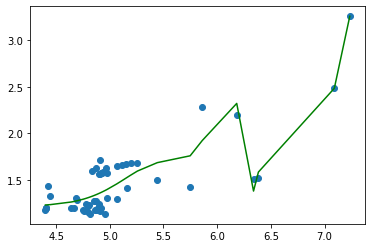

Root Mean Square Error:  0.16536302559064875


Use polynomial regression with degree = 47: 


Model coefficient:  [[-8.73286193e-28  3.53519039e-27 -1.08404976e-27  1.30163771e-28
  -1.18509036e-28  4.83870067e-29 -1.96833458e-29  1.05890311e-28
   1.21905848e-27 -7.84675762e-27 -8.32313479e-27  9.09127954e-30
   2.50573556e-30  4.58367661e-28  2.23847942e-27 -2.14900761e-27
  -9.44129493e-40 -4.25553978e-39 -1.89136493e-38 -8.28023089e-38
  -3.56540149e-37 -1.50706441e-36 -6.23759054e-36 -2.51951468e-35
  -9.88718781e-35 -3.74565642e-34 -1.35701128e-33 -4.63060092e-33
  -1.44776205e-32 -3.90154314e-32 -7.41932461e-32  3.09599485e-32
   1.31728236e-30  9.07993656e-30  4.59979145e-29  1.96241974e-28
   7.28101993e-28  2.34336005e-27  6.36256543e-27  1.36480690e-26
   1.96225374e-26  8.39274926e-27 -2.14343910e-26  1.03816284e-26
  -2.38469027e-27  2.95201891e-28 -1.90808900e-29  5.07513202e-31]]
Model intercept:  [1.23125357]


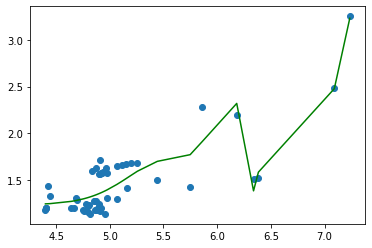

Root Mean Square Error:  0.16712163257872764


Use polynomial regression with degree = 48: 


Model coefficient:  [[-1.84181578e-28 -1.49927340e-28 -3.18020744e-28  3.18093998e-29
  -1.33382479e-29  4.98259141e-30 -1.24121805e-30 -6.97400624e-30
   7.27318389e-29 -8.16394082e-28  5.66089591e-28 -1.92097039e-27
   1.00443240e-27 -2.16449763e-28 -1.02098075e-27  3.37164356e-42
   1.61188301e-41  7.88499424e-41  3.82751542e-40  1.84321553e-39
   8.80276622e-39  4.16707040e-38  1.95406158e-37  9.06998510e-37
   4.16324882e-36  1.88770484e-35  8.44382559e-35  3.72020807e-34
   1.61141075e-33  6.84672029e-33  2.84589306e-32  1.15338638e-31
   4.53908745e-31  1.72566150e-30  6.29584672e-30  2.18509720e-29
   7.12941024e-29  2.15037896e-28  5.84733872e-28  1.37633315e-27
   2.60152648e-27  3.30530210e-27  1.08646593e-27 -3.38716322e-27
   1.67736543e-27 -3.88656965e-28  4.83247921e-29 -3.13131292e-30
   8.34066846e-32]]
Model intercept:  [1.24451918]


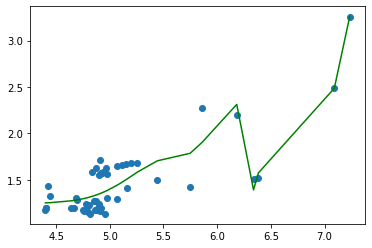

Root Mean Square Error:  0.16886692645336687


Use polynomial regression with degree = 49: 


Model coefficient:  [[-4.03427593e-29 -8.97517292e-29  1.71811008e-30  3.77632240e-29
  -1.09067484e-29 -5.83245990e-32  7.20722523e-31 -1.44464287e-29
  -1.49941785e-28 -1.53241886e-28  1.28168590e-28  7.18383289e-29
  -4.60915350e-29 -1.32082904e-28 -2.08673991e-28 -2.71190579e-30
  -1.04101784e-42 -4.83698631e-42 -2.14642247e-41 -9.38786138e-41
  -4.04074994e-40 -1.70809856e-39 -7.07181004e-39 -2.85688072e-38
  -1.12023085e-37 -4.23040292e-37 -1.51952468e-36 -5.07825253e-36
  -1.50791314e-35 -3.48907694e-35 -2.38321700e-35  3.98453080e-34
   3.55400257e-33  2.13241264e-32  1.07888442e-31  4.87692898e-31
   2.00669657e-30  7.53390720e-30  2.55943989e-29  7.71571041e-29
   1.99006698e-28  4.09108931e-28  5.65826028e-28  2.25674350e-28
  -6.04386407e-28  2.93829938e-28 -6.75066148e-29  8.34921704e-30
  -5.38941281e-31  1.43125166e-32]]
Model intercept:  [1.25585217]


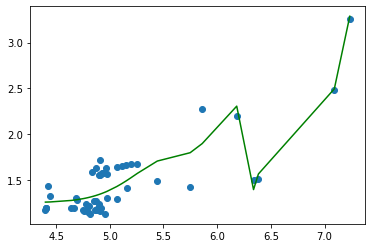

Root Mean Square Error:  0.17078039091484368


Use polynomial regression with degree = 50: 


Model coefficient:  [[-8.89767903e-30  1.07173360e-30 -1.47864465e-29 -5.59044494e-30
   2.72477656e-30 -1.14376627e-30  3.68602242e-31 -3.05941852e-30
  -1.11975178e-30 -4.51565972e-30  2.35697730e-30  5.03907167e-30
   8.43107771e-29 -3.50092407e-29  1.03657817e-31  1.60888253e-44
   8.05284792e-44  3.80476887e-43  1.78438561e-42  8.30589929e-42
   3.83645143e-41  1.75783725e-40  7.98633099e-40  3.59584018e-39
   1.60342978e-38  7.07538145e-38  3.08665553e-37  1.32977105e-36
   5.64987044e-36  2.36367780e-35  9.71875882e-35  3.91857923e-34
   1.54511182e-33  5.93827048e-33  2.21533278e-32  7.98073350e-32
   2.75787840e-31  9.06192446e-31  2.79763885e-30  7.97885733e-30
   2.04954221e-29  4.55022708e-29  8.08750064e-29  9.57082705e-29
   2.56847509e-29 -9.38881698e-29  4.71077070e-29 -1.09596855e-29
   1.36451851e-30 -8.84291670e-32  2.35431001e-33]]
Model intercept:  [1.26754994]


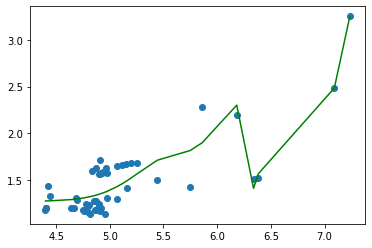

Root Mean Square Error:  0.17248684655539157


Min rmse: 0.14936393888872537 with model with degree: 30


In [1]:
from numpy.lib import polynomial
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def getData(post_type, street, ward, district):
    
    conn = psycopg2.connect(database="real_estate_data", user="postgres", password="361975Warcraft")
    # cur = conn.cursor()
    query = """
        SELECT area, price, street, ward, district
        FROM bds_realestatedata 
        WHERE
            post_type = '{}' AND
            area IS NOT NULL AND
            price IS NOT NULL AND
            street = '{}' AND
            ward = '{}' AND
            district = '{}';
    """.format(post_type, street, ward, district)
    
    # cur.execute(query)
    # data = cur.fetchall()
    data = pd.read_sql_query(query, con=conn)
    
#     print(data.head())
#     print("Data length: {}\n".format(len(data)))

    return prepareData(data)
#     return data

def prepareData(data):
    
    # Drop duplicates:    
    data.drop_duplicates(subset='area', keep='first', inplace=True)
    
    # Sort data by area column:
    data = data.sort_values(by=['area'])

    # use percentiles to remove outliers:
    area_upper_bound = data['area'].quantile(0.95)
    area_lower_bound = data['area'].quantile(0.05)
    price_upper_bound = data['price'].quantile(0.95)
    price_lower_bound = data['price'].quantile(0.05)

    data = data[
        (data['area'] < area_upper_bound) &
        (data['area'] > area_lower_bound) &
        (data['price'] < price_upper_bound) &
        (data['price'] > price_lower_bound)
    ]
    
#     print(data.head())
#     print("Data length: {}\n".format(len(data)))

#     Use log transformation to scale data:

    log_transform_area = (data['area']+1).transform(np.log)
    log_transform_price = (data['price']+1).transform(np.log)
    log_transform_data = pd.DataFrame({'area': log_transform_area, 'price': log_transform_price, 'street': data['street'], 'ward': data['ward'], 'district': data['district']})

    print("--------------------------------------------------------")
    print(log_transform_data.head())
    print("--------------------------------------------------------")
    print("Log Transformation Data length: ", len(log_transform_data))

    return log_transform_data
#     return data

def splitData(data):
    # Selection few attributes
    attributes = ['area',]
    predict_val = ['price']
    
    # Vector attributes of lands
    X = data[attributes]
    # Vector price of land
    Y = data[predict_val]
    
    # Convert into arr:
    X = np.array(X)
    Y = np.array(Y)
    
    # Split data to training test and testing test
    # training data : testing data = 80 : 20
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
    # return X_train, X_test, Y_train, Y_test
    
    return X, Y

# Linear Regression Model:
def linearRegressionModel(X, Y):
    model = linear_model.LinearRegression()

    # Training process
    model.fit(X, Y)
    
    # return model coefficient, intercept:
    return model

# Polynomial Regression:
def polynomialRegression(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    # calc linear regression again:
    poly_model = linearRegressionModel(X_poly, Y)
    return poly_model, X_poly

def degree_test(degree):
    print("\n\nUse polynomial regression with degree = {}: \n\n".format(degree))
    
    # Call polynomial regression
    poly_model, X_poly = polynomialRegression(degree)
    
    poly_model_coef = poly_model.coef_
    poly_model_intercept = poly_model.intercept_
    Y_poly_pred = poly_model.predict(X_poly)
    
    print("Model coefficient: ", poly_model_coef)
    print("Model intercept: ", poly_model_intercept)
    
    # print("Model: y = {} + {}x + {}x^2 + {}".format(model_coef[0], model_coef[1], model_coef[2], model_intercept))

    # Plot model:
    plt.scatter(X, Y)
    # plt.plot(X, poly_model_coef[0] + poly_model_coef[1]*X + poly_model_coef[2]*pow(X, 2) + poly_model_intercept, color='red')
    plt.plot(X, Y_poly_pred, color='green')
    plt.show()

    # Find root mean square error of model between Y_predict and Y
    rmse = np.sqrt(mean_squared_error(Y, Y_poly_pred))
    print("Root Mean Square Error: ", rmse)

    return poly_model, rmse

# Data:
post_type = 'Bán đất'
street = 'Hoàng Phan Thái'
ward = 'Bình Chánh'
district = 'Bình Chánh'

data = getData(post_type, street, ward, district)
X, Y = splitData(data)

model = linearRegressionModel(X, Y)
model_coef = model.coef_
model_intercept = model.intercept_
Y_pred = model.predict(X)

""" 
y = ax1 + b
[a] is coefficient
b is intercept
"""

print("Model coefficient: ", model_coef)
print("Model intercept ", model_intercept)

# Plot model:
plt.scatter(X, Y)
# plt.plot(X, model_coef*X + model_intercept, color='y')
plt.plot(X, Y_pred, color='yellow')
plt.show()

# Find root mean square error of model between Y_predict and Y
linear_rmse = np.sqrt(mean_squared_error(Y, Y_pred))
print("Root Mean Square Error: ", linear_rmse)

min_rmse = linear_rmse
selected_model = linear_model
degree = 1
for i in range(2, 51):
    poly_model, rmse = degree_test(i)
    if rmse < min_rmse:
        min_rmse = rmse
        selected_model = poly_model
        degree = i
print("\n\nMin rmse: {} with model with degree: {}".format(min_rmse, degree))